In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
import gensim.models.keyedvectors as word2vec
import gc
import warnings

from tqdm import tqdm
tqdm.pandas()
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
print(train.shape)
print(test.shape)

(159571, 8)
(153164, 2)


In [3]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

In [4]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [5]:
"There are %d words in the dictionary" %len(tokenizer.word_counts)

'There are 210337 words in the dictionary'

In [6]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

# Word Embeddings
# 1. GloVe

In [17]:
EMBEDDING_FILE='glove/glove.twitter.27B.25d.txt'
embed_size = 25
embeddings_index = dict()

f = open(EMBEDDING_FILE)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

gc.collect()

Loaded 1193514 word vectors.


0

In [18]:
del embeddings_index['0.065581']
all_embs = np.stack(list(embeddings_index.values()))
emb_mean,emb_std = all_embs.mean(), all_embs.std()

nb_words = len(tokenizer.word_index)

glove25 = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
gc.collect()


embeddedCount = 0
for word, i in tokenizer.word_index.items():
    i-=1

    embedding_vector = embeddings_index.get(word)

    if embedding_vector is not None: 
        glove25[i] = embedding_vector
        embeddedCount+=1
print('total embedded:',embeddedCount,'common words')

del(embeddings_index)
gc.collect()

total embedded: 81610 common words


0

In [19]:
glove25

array([[-0.010167  ,  0.020194  ,  0.21472999, ...,  0.18783   ,
        -0.84249997, -0.31208   ],
       [ 0.28228   ,  0.019558  ,  0.11509   , ...,  0.21430001,
         0.25422001, -0.26673999],
       [ 0.32543001, -0.089637  , -0.14733   , ..., -0.61750001,
        -0.54592001, -0.069893  ],
       ...,
       [-0.00684513, -0.84489406, -0.12150688, ..., -0.20902332,
         1.57896398,  1.04860937],
       [-0.045856  ,  0.53393   , -0.37573001, ..., -0.35626999,
        -1.45319998, -0.26989999],
       [ 0.45367   ,  1.06959999, -1.19630003, ..., -0.040364  ,
        -0.51828003, -0.24542999]])

# 2. Word2Vec

We use Google News Negative 300 pre-trained word2vec embedding.

The pre-trained embedding file is too large and cannot be uploaded to Github. It can be downloaded here: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit

In [25]:
word2vecDict = word2vec.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)
embed_size = 300

In [26]:
embeddings_index = dict()
for word in word2vecDict.wv.vocab:
    embeddings_index[word] = word2vecDict.word_vec(word)
print('Loaded %s word vectors from pretrained word2vec embeddings.' % len(embeddings_index))
gc.collect()

all_embs = np.stack(list(embeddings_index.values()))
emb_mean,emb_std = all_embs.mean(), all_embs.std()



nb_words = len(tokenizer.word_index)

google300 = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
gc.collect()


embeddedCount = 0
for word, i in tokenizer.word_index.items():
    i-=1
    
    embedding_vector = embeddings_index.get(word)
    
    if embedding_vector is not None: 
        google300[i] = embedding_vector
        embeddedCount+=1
print('total embedded:',embeddedCount,'common words')

del(embeddings_index)
gc.collect()

Loaded 3000000 word vectors from pretrained word2vec embeddings.
total embedded: 66078 common words


0

In [27]:
google300

array([[ 0.08007812,  0.10498047,  0.04980469, ...,  0.00366211,
         0.04760742, -0.06884766],
       [-0.1151491 ,  0.11157137,  0.25658163, ...,  0.18488426,
        -0.13484488,  0.0725175 ],
       [ 0.26559048, -0.07973897,  0.04335168, ...,  0.2941775 ,
        -0.1000641 ,  0.23981965],
       ...,
       [-0.24030975, -0.20096584, -0.10210556, ..., -0.04216994,
         0.21718019, -0.05437023],
       [ 0.25585938,  0.13085938,  0.13574219, ...,  0.15136719,
         0.13085938, -0.36523438],
       [ 0.21424275,  0.00261933, -0.18658625, ...,  0.03554782,
         0.10970153, -0.00894466]])

# 3. FastText

In [28]:
EMBEDDING_FILE='wiki-news-300d-1M.vec'
embed_size = 300

In [31]:
embeddings_index = dict()

f = open(EMBEDDING_FILE)
for line in f:
    
    values = line.split()
    
    word = values[0]
    
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs #50 dimensions
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

gc.collect()

del embeddings_index['999994']
all_embs = np.stack(list(embeddings_index.values()))
emb_mean,emb_std = all_embs.mean(), all_embs.std()



nb_words = len(tokenizer.word_index)

wiki300 = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
gc.collect()


embeddedCount = 0
for word, i in tokenizer.word_index.items():
    i-=1
    
    embedding_vector = embeddings_index.get(word)
    
    if embedding_vector is not None: 
        wiki300[i] = embedding_vector
        embeddedCount+=1
print('total embedded:',embeddedCount,'common words')

del(embeddings_index)
gc.collect()

Loaded 999995 word vectors.
total embedded: 88231 common words


0

In [36]:
print("Dimensions of GloVe embedding:", glove25.shape)
print("Dimensions of Word2Vec embedding:", google300.shape)
print("Dimensions of FastText embedding:", wiki300.shape)

Dimensions of GloVe embedding: (210337, 25)
Dimensions of Word2Vec embedding: (210337, 300)
Dimensions of FastText embedding: (210337, 300)


# Training Model

In [37]:
inp = Input(shape=(maxlen, ))

## GloVe

In [41]:
x = Embedding(len(tokenizer.word_index), glove25.shape[1],weights=[glove25],trainable=False)(inp)

In [39]:
x = Bidirectional(LSTM(60, return_sequences=True,name='lstm_layer',dropout=0.1,recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 25)           5258425   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 120)          41280     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 120)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                6050      
___________________________

In [40]:
batch_size = 32
epochs = 4
hist = model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 143613 samples, validate on 15958 samples
Epoch 1/4
143613/143613 [==============================] - 835s 6ms/step - loss: 0.1167 - acc: 0.9653 - val_loss: 0.0913 - val_acc: 0.9709
Epoch 2/4
143613/143613 [==============================] - 818s 6ms/step - loss: 0.0886 - acc: 0.9725 - val_loss: 0.0805 - val_acc: 0.9742
Epoch 3/4
143613/143613 [==============================] - 832s 6ms/step - loss: 0.0798 - acc: 0.9748 - val_loss: 0.0745 - val_acc: 0.9755
Epoch 4/4
143613/143613 [==============================] - 843s 6ms/step - loss: 0.0754 - acc: 0.9760 - val_loss: 0.0707 - val_acc: 0.9764


## Word2Vec

In [42]:
x = Embedding(len(tokenizer.word_index), google300.shape[1],weights=[google300],trainable=False)(inp)

In [43]:
x = Bidirectional(LSTM(60, return_sequences=True,name='lstm_layer',dropout=0.1,recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 200, 300)          63101100  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200, 120)          173280    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 120)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                6050      
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
__________

In [44]:
batch_size = 32
epochs = 4
hist = model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/4
143613/143613 [==============================] - 1441s 10ms/step - loss: 0.0827 - acc: 0.9748 - val_loss: 0.0606 - val_acc: 0.9794
Epoch 2/4
143613/143613 [==============================] - 1515s 11ms/step - loss: 0.0574 - acc: 0.9803 - val_loss: 0.0542 - val_acc: 0.9812
Epoch 3/4
143613/143613 [==============================] - 2391s 17ms/step - loss: 0.0517 - acc: 0.9819 - val_loss: 0.0520 - val_acc: 0.9812
Epoch 4/4
143613/143613 [==============================] - 1954s 14ms/step - loss: 0.0481 - acc: 0.9827 - val_loss: 0.0512 - val_acc: 0.9816


## FastText

In [45]:
x = Embedding(len(tokenizer.word_index), wiki300.shape[1],weights=[wiki300],trainable=False)(inp)

In [46]:
x = Bidirectional(LSTM(60, return_sequences=True,name='lstm_layer',dropout=0.1,recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 200, 300)          63101100  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200, 120)          173280    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 120)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                6050      
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
__________

In [47]:
batch_size = 32
epochs = 4
hist = model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Train on 127656 samples, validate on 31915 samples
Epoch 1/4
127656/127656 [==============================] - 1334s 10ms/step - loss: 0.0886 - acc: 0.9734 - val_loss: 0.0649 - val_acc: 0.9789
Epoch 2/4
127656/127656 [==============================] - 1330s 10ms/step - loss: 0.0629 - acc: 0.9793 - val_loss: 0.0573 - val_acc: 0.9804
Epoch 3/4
127656/127656 [==============================] - 1341s 11ms/step - loss: 0.0565 - acc: 0.9806 - val_loss: 0.0557 - val_acc: 0.9809
Epoch 4/4
127656/127656 [==============================] - 1358s 11ms/step - loss: 0.0527 - acc: 0.9815 - val_loss: 0.0534 - val_acc: 0.9815


# Performance Comparison

In [52]:
all_losses = {
'word2vec_loss': [0.0827,
  0.0574,
  0.0517,
  0.0481],
 'word2vec_val_loss': [0.0606,
  0.0542,
  0.0520,
  0.0512],
'glove_loss': [0.1167,
  0.0886,
  0.0798,
  0.0754],
 'glove_val_loss': [0.0913,
  0.0805,
  0.0745,
  0.0707],
 'fasttext_loss': [0.0886,
  0.0629,
  0.0565,
  0.0527],
 'fasttext_val_loss': [0.0649,
  0.0573,
  0.0557,
  0.0534],
 'baseline_loss': [0.1015,
  0.0586,
  0.0521,
  0.0489],
 'baseline_val_loss': [0.0644,
  0.0551,
  0.0511,
  0.0509]
}

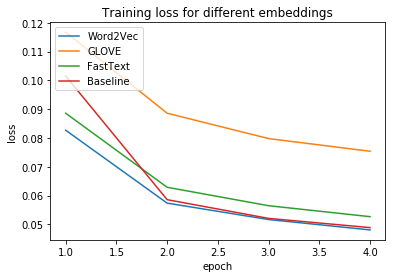

In [53]:
epochRange = np.arange(1,5,1)
plt.plot(epochRange,all_losses['word2vec_loss'])
plt.plot(epochRange,all_losses['glove_loss'])
plt.plot(epochRange,all_losses['fasttext_loss'])
plt.plot(epochRange,all_losses['baseline_loss'])
plt.title('Training loss for different embeddings')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Word2Vec', 'GLOVE','FastText','Baseline'], loc='upper left')
plt.show()

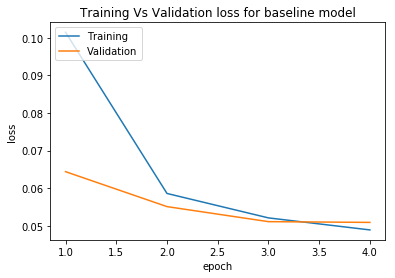

In [54]:
epochRange = np.arange(1,5,1)
plt.plot(epochRange,all_losses['baseline_loss'])
plt.plot(epochRange,all_losses['baseline_val_loss'])
plt.title('Training Vs Validation loss for baseline model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

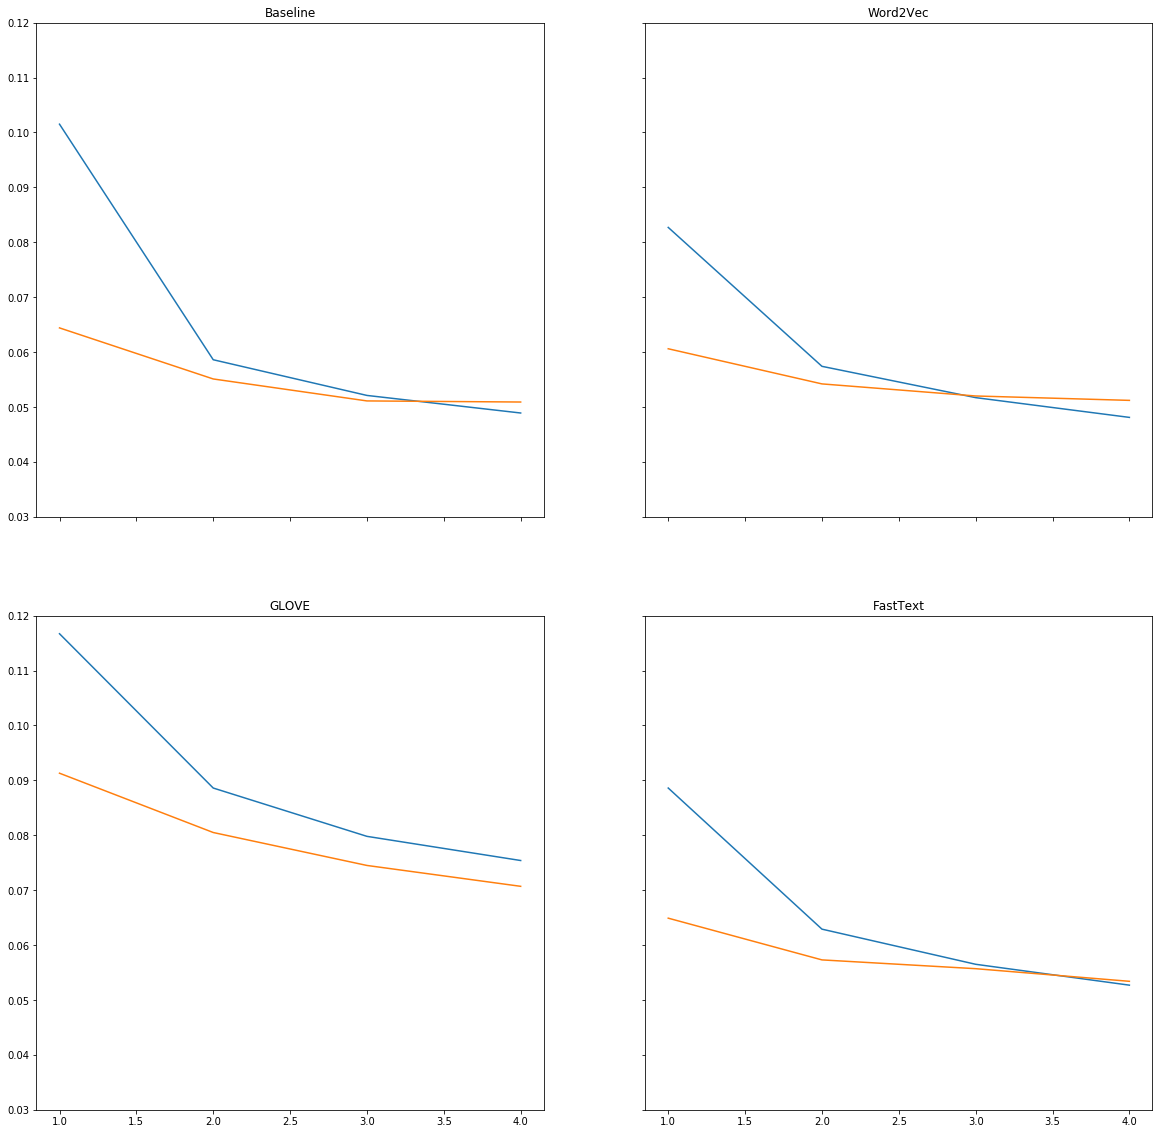

In [55]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row',figsize=(20, 20))

plt.title('Training Vs Validation loss for all embeddings')
ax1.plot(epochRange,all_losses['baseline_loss'])
ax1.plot(epochRange,all_losses['baseline_val_loss'])
ax1.set_title('Baseline')
ax1.set_ylim(0.03, 0.12)

ax2.plot(epochRange,all_losses['word2vec_loss'])
ax2.plot(epochRange,all_losses['word2vec_val_loss'])
ax2.set_title('Word2Vec')
ax2.set_ylim(0.03, 0.12)

ax3.plot(epochRange,all_losses['glove_loss'])
ax3.plot(epochRange,all_losses['glove_val_loss'])
ax3.set_title('GLOVE')
ax3.set_ylim(0.03, 0.12)


ax4.plot(epochRange,all_losses['fasttext_loss'])
ax4.plot(epochRange,all_losses['fasttext_val_loss'])
ax4.set_title('FastText')
ax4.set_ylim(0.03, 0.12)

plt.show()